# Conv4 3D Residual

In [1]:
from keras.models import  load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras.backend as K
from cnn_utils import *

# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
model = load_model('networks/conv4_3d_res_v1_e150.h5') 

In [4]:
loss, valoss, rocs = load_outputs(epochs=['10','50','75','100','125','150'])

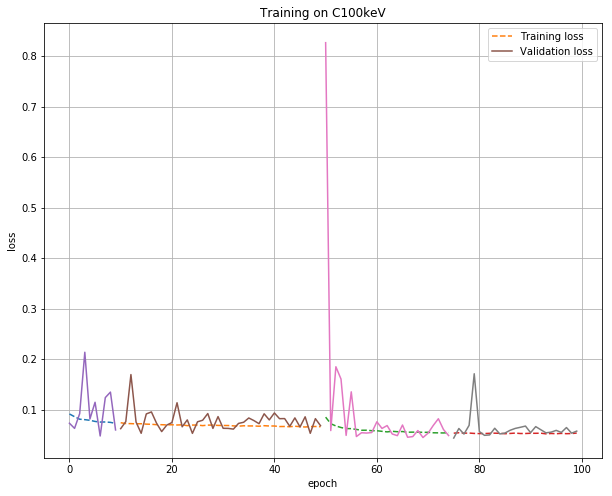

In [5]:
plt.figure(figsize=(10,8))
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training on C100keV')

plt.plot(range(10),loss['10'],'--')
plt.plot(range(10,50),loss['50'],'--', label='Training loss')
plt.plot(range(50,75),loss['75'],'--')
plt.plot(range(75,100),loss['100'],'--')

plt.plot(range(10),valoss['10'])
plt.plot(range(10,50),valoss['50'], label='Validation loss')
plt.plot(range(50,75),valoss['75'])
plt.plot(range(75,100),valoss['100'])

plt.legend()
#plt.yscale('log')

In [6]:
print('''Epoch 0-50\t Drop_middle=Drop_end=0.7, Drop_resid_conv=0.3
Epoch 50-75\t -//-, Drop_resid_conv=0.4, beta_1=0.95(Adam), MaxNorm=4.0 (weights)
Epoch 75-100\t -//-, reduce_LR_on_plateau
Epoch 100-125\t -//-, signal C30 instead of C100
Epoch 125-150\t -//-, signal C60 instead of C100''')

Epoch 0-50	 Drop_middle=Drop_end=0.7, Drop_resid_conv=0.3
Epoch 50-75	 -//-, Drop_resid_conv=0.4, beta_1=0.95(Adam), MaxNorm=4.0 (weights)
Epoch 75-100	 -//-, reduce_LR_on_plateau
Epoch 100-125	 -//-, signal C30 instead of C100
Epoch 125-150	 -//-, signal C60 instead of C100


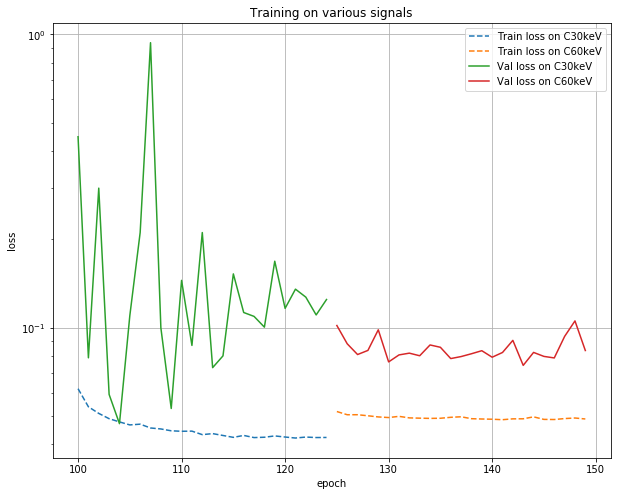

In [7]:
plt.figure(figsize=(10,8))
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training on various signals')

plt.plot(range(100,125),loss['125'],'--', label='Train loss on C30keV')
plt.plot(range(125,150),loss['150'],'--', label='Train loss on C60keV')

plt.plot(range(100,125),valoss['125'], label='Val loss on C30keV')
plt.plot(range(125,150),valoss['150'], label='Val loss on C60keV')

plt.legend()
plt.yscale('log')

### C100keV Test

In [8]:
X_test, y_test = load_data(sig_n='C100keV',training=False)

X_test shape:	(41754, 32, 32, 8, 1)
y_test shape:	(41754,)


In [9]:
preds = model.predict(X_test,batch_size=64, verbose=1)
print('roc_auc:\t',round(roc_auc_score(y_test, preds), 5))

41754/41754 [==============================] - 64s    
roc_auc:	 0.998


In [10]:
# 1st column = output, 2nd column = index
pos, neg = pos_neg(y_test, preds)

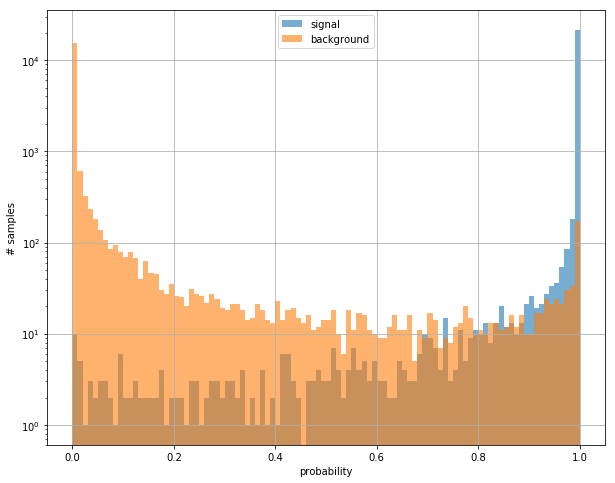

In [11]:
plt.figure(figsize=(10,8))
plt.hist(pos[:,0], bins=100, label='signal', alpha=0.6)
plt.hist(neg[:,0], bins=100, label='background', alpha=0.6)
plt.grid()
plt.yscale('log')
plt.ylabel('# samples')
plt.xlabel('probability')
plt.legend()

Output probability threshold plotted between:
	 0.9997074 	 0.9999999


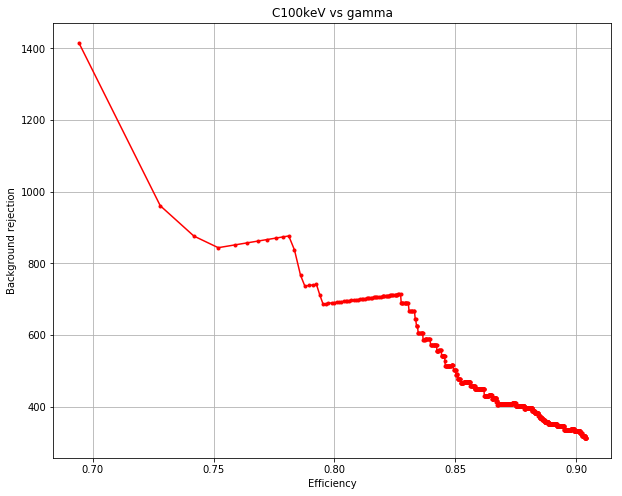

In [12]:
prec_curve, rec_curve, thr_curve = precision_recall_curve(y_test, preds)
plt.figure(figsize=(10,8))
plt.grid()
plt.title('C100keV vs gamma')
plt.plot(rec_curve[-1000:-1],(1-prec_curve[-1000:-1])**-1,'r.-')
plt.xlabel('Efficiency')
plt.ylabel('Background rejection')

print('Output probability threshold plotted between:\n\t',thr_curve[-1000],'\t',thr_curve[-2])

### C60keV Test

In [13]:
X_test, y_test = load_data(sig_n='C60keV',training=False)

X_test shape:	(37999, 32, 32, 8, 1)
y_test shape:	(37999,)


In [14]:
preds = model.predict(X_test,batch_size=64, verbose=1)
print('roc_auc:\t',round(roc_auc_score(y_test, preds), 5))

37999/37999 [==============================] - 57s    
roc_auc:	 0.99762


In [15]:
# 1st column = output, 2nd column = index
pos, neg = pos_neg(y_test, preds)

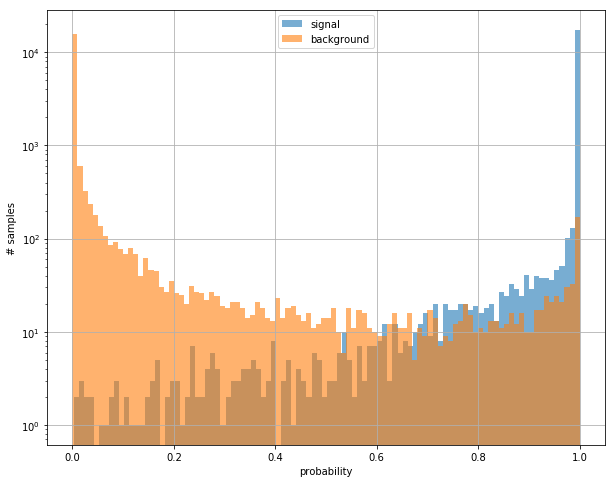

In [16]:
plt.figure(figsize=(10,8))
plt.hist(pos[:,0], bins=100, label='signal', alpha=0.6)
plt.hist(neg[:,0], bins=100, label='background', alpha=0.6)
plt.grid()
plt.yscale('log')
plt.ylabel('# samples')
plt.xlabel('probability')
plt.legend()

Output probability threshold plotted between:
	 0.9988073 	 0.9999999


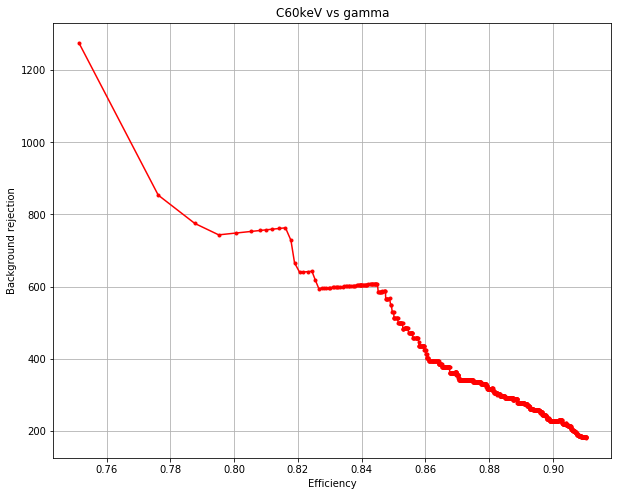

In [17]:
prec_curve, rec_curve, thr_curve = precision_recall_curve(y_test, preds)
plt.figure(figsize=(10,8))
plt.grid()
plt.title('C60keV vs gamma')
plt.plot(rec_curve[-1000:-1],(1-prec_curve[-1000:-1])**-1,'r.-')
plt.xlabel('Efficiency')
plt.ylabel('Background rejection')

print('Output probability threshold plotted between:\n\t',thr_curve[-1000],'\t',thr_curve[-2])

### C30keV Test

In [18]:
X_test, y_test = load_data(sig_n='C30keV',training=False)

X_test shape:	(36822, 32, 32, 8, 1)
y_test shape:	(36822,)


In [19]:
preds = model.predict(X_test,batch_size=64, verbose=1)
print('roc_auc:\t',round(roc_auc_score(y_test, preds), 5))

36822/36822 [==============================] - 55s    
roc_auc:	 0.998


In [20]:
# 1st column = output, 2nd column = index
pos, neg = pos_neg(y_test, preds)

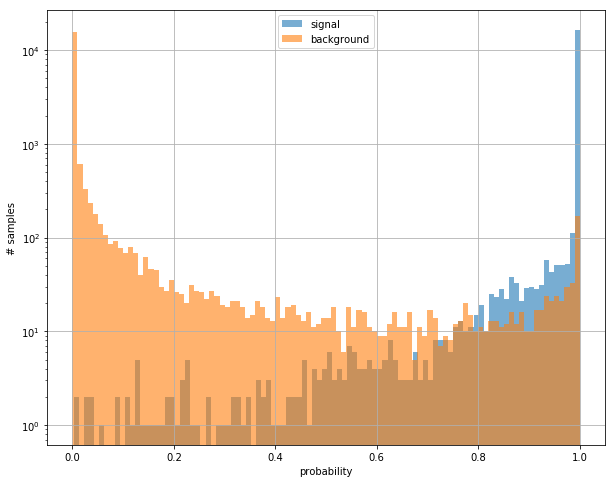

In [21]:
plt.figure(figsize=(10,8))
plt.hist(pos[:,0], bins=100, label='signal', alpha=0.6)
plt.hist(neg[:,0], bins=100, label='background', alpha=0.6)
plt.grid()
plt.yscale('log')
plt.ylabel('# samples')
plt.xlabel('probability')
plt.legend()

Output probability threshold plotted between:
	 0.9983931 	 0.9999999


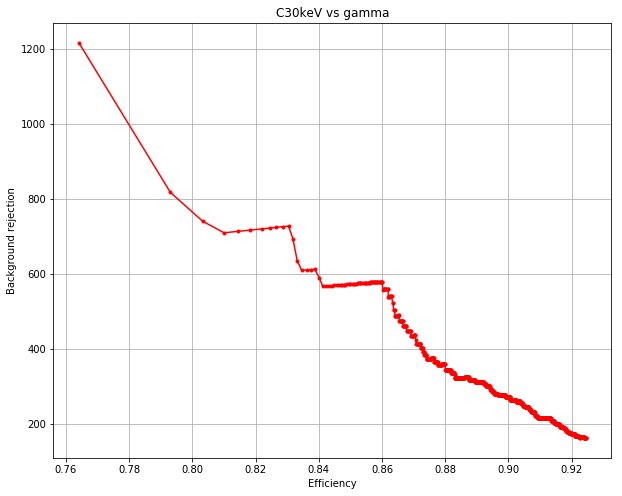

In [25]:
prec_curve, rec_curve, thr_curve = precision_recall_curve(y_test, preds)
plt.figure(figsize=(10,8))
plt.grid()
plt.title('C30keV vs gamma')
plt.plot(rec_curve[-1000:-1],(1-prec_curve[-1000:-1])**-1,'r.-')
plt.xlabel('Efficiency')
plt.ylabel('Background rejection')

print('Output probability threshold plotted between:\n\t',thr_curve[-1000],'\t',thr_curve[-2])